In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import json
from IPython.core.debugger import set_trace #Pour debugger

In [2]:
class Point:
    """Classe définissant un point sur la carte"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return f"({self.x},{self.y})"

In [3]:
class Client:
    def __init__(self, nom, position, ready_time, due_time, demand):
        """Représente un client :
        - nom : nom du client
        - position : Objet Point indiquant la position de la boutique du client à livrer
        - ready_time : Heure d'ouverture
        - due_time : Heure de fermeture
        - demand : Quantité de colis à livrer / poids du colis"""
        self.nom = nom
        self.position = position
        self.dict = {}
        self.dict["demand"] = demand
        self.dict["ready_time"] = ready_time
        self.dict["due_time"] = due_time
        
    def __repr__(self):
        """On represente un client par son nom"""
        return self.nom

In [4]:
def Distance(p1, p2):
    """Distance entre deux objets points
    Ici c'est a distance euclidienne, mais plus tard ce sera la distance routière.
    Cette fonction pourra également être remplacé par une fonction 'côut' qui donne le cout du chemin de p1 vers p2"""
    return np.sqrt((p1.x-p2.x)**2 + (p1.y-p2.y)**2)

def DistanceEntreDeuxClients(C1,C2):
    return Distance(C1.position, C2.position)
    

In [5]:
class Situation:
    """Classe décrivant la situation du marché à l'instant T,
    c'est à dire tous les clients que nous devons livrer + l'ELP + la carte"""
    def __init__(self, ELP, Liste_Clients, n_triporteurs_a_disposition):
        self.ELP = ELP
        self.Liste_Clients = Liste_Clients
        self.n_triporteurs_a_disposition = n_triporteurs_a_disposition
        
    def Plt(self):
        """Retourne les coordonées des clients et de l'ELP sous la forme X,Y,couleur"""
        X,Y,C = [self.ELP.position.x],[self.ELP.position.y],["r"] #Du rouge
        for client in self.Liste_Clients:
            X.append(client.position.x)
            Y.append(client.position.y)
            C.append("b") #Du bleu
        return X,Y,C
        

In [6]:
def partition (l, n):
    """Créé une partition de n éléments de la liste"""
    random.shuffle(l)
    return [l[i::n] for i in range(n)]

## Algorithme Génétique

In [34]:
class AG:
    """Classe contenant toutes les méthodes pour résoudre le problème"""
    def __init__(self, situation, pop = 3000, n_generations = 300,
                 p_meilleurs = 0.20, p_randoms = 0.15, p_clones = 0.50,
                 n_max_mutations = 10):
        """
        - situation : Objet Situation donnant la situation acutelle
        - pop : taille de la population à la première génération
        - p_meilleurs : proportion des meilleurs individus à garder d'une génération à l'autre
        - p_randoms : proportion des quelques heureux qui seront acceptés malgré leurs moins bonnes performances
        - p_clones : proportion de clones qui vont être muter d'une génération à l'autre
        - n_max_mutations : nombre max de mutation possible sur un clone pour le différencier de ses parents
        """
        
        self.situation = situation 
        self.pop = pop
        self.n_generations = n_generations
        self.p_meilleurs = p_meilleurs
        self.p_randoms = p_randoms
        self.p_clones = p_clones
        self.n_max_mutations = n_max_mutations
        
        # Il est important que plus le nombre de génération est importante, plus l'on converge vers une bonne solution
        # Ainsi, la diversité génétique est surtout importante au début, ainsi que le nombre de mutation
        # Vers la fin, on a tendance a diminuer le nombre de mutation et la taille de la population
        
        # Arbitrairement, on fixe que la population a la fin ne vaut plus que 20% de la pop initiale
        #Reste a trouver un nombre g tel que : pop_min = g^n_generations x pop_i, donc g^n_generations = 1/5 = 20%,
        #et donc :
        self.gamma_pop = np.power(0.20, 1/n_generations)
        #self.gamma_pop = 1
        
        # De la même facon on veut diminuer au cours du temps le nombre max de mutations qui doit tomber à 2
        # Donc si 2 = n_mutations_max * g^n_generations, alors 
        self.gamma_mutations = np.power(2/n_max_mutations, 1/n_generations)
        #self.gamma_mutations = 1
        
    def nouvelle_repartition_quelconque(self):
        """Retourne une tentative de répartition des colis parmis les triporteur pour résoudre le problème"""
        #1) On décide combien de triporteur nous allons utiliser
        n_triporteurs_utilises = self.situation.n_triporteurs_a_disposition
        
        #2) On distribue alors complétement aléatoirement les clients pour chaque triporteurs
        repartition = partition(self.situation.Liste_Clients, n_triporteurs_utilises)
        
        #3) On ajoute alors l'ELP comme point de départ et d'arrivé
        for k in range(len(repartition)):
            repartition[k] = [self.situation.ELP] + repartition[k] + [self.situation.ELP]
        
        #Si l'un des éléments de repartition est initalement faux, on le montre
        for chemin in repartition:
            if len(chemin) == 2:
                set_trace()
        
        return repartition
    
    def nouvelle_generation_quelconque(self):
        """Creer une nouvelle generation totalement au hasard"""
        return [self.nouvelle_repartition_quelconque() for _ in range(self.pop)]
    
    def score_repartition(repartition):
        """Retourne le score d'une répartition, simplement en sommant la distance des points deux à deux"""
        S = 0
        for chemin_triporteur in repartition:
            s = 0
            for i_etape in range(len(chemin_triporteur)-1):
                s += DistanceEntreDeuxClients(chemin_triporteur[i_etape], chemin_triporteur[i_etape+1])
            S+=s**2
        return S
    
    def score_generation(generation):
        """Donne le score de toute une generation, en renvoyant une liste de la forme [(tentative, score)]"""
        _ = []
        for repartition in generation:
            _.append((repartition, AG.score_repartition(repartition)))
        return _
    
    def evolution(self, generation):
        "Retourne les élements qui vont se reproduire pour donner la nouvelle génération"
        #0) On met a jour la taille de la population ainsi que le nombre maximum de mutations
        self.pop *= self.gamma_pop
        self.n_max_mutations *= self.gamma_mutations
        if self.verbal :
            print(f"pop = {self.pop}")
        
        #1) On prend les meilleurs
        n_meilleurs = int(round(self.pop*self.p_meilleurs))
        if self.verbal :
            print(f"n_meilleurs = {n_meilleurs}")
        performances = AG.score_generation(generation)
        performances_triees = sorted(performances, key=lambda x: x[1]) # On tri en ordre croissant : les plus performants sont donc les premiers, car chemin le moins couteux
        new_generation = [x[0] for x in performances_triees[:n_meilleurs]]
        
        #2) On ajoute les quelques heureux élus qui sont pris malgré tout pour la diversité génétique
        n_randoms = int(round(self.pop*self.p_randoms))
        if self.verbal:
            print(f"n_randoms = {n_randoms}")
        for _ in range(n_randoms):
            ix = np.random.randint(n_meilleurs+1, len(generation))
            new_generation.append(performances_triees[ix][0])
            
        #3) On ajoute des nouveaux membres basés sur des mutations des anciens
        n_clones = int(round(self.pop*self.p_clones))
        if self.verbal:
            print(f"n_clones = {n_clones}")
        for _ in range(n_clones):
            clone = AG.clone(new_generation[np.random.randint(n_meilleurs + n_randoms)])
            new_generation.append(clone)
            #On tire un nombre aléatoire de mutation
            for __ in range(int(round(self.n_max_mutations))):
                self.faire_muter(clone)
            
        if self.verbal:
            print(f"Taille de new_generation : {len(new_generation)}")
        return new_generation
    
    def meilleur_et_moyenne(generation):
        """Renvoie le meilleur élément d'une génération ainsi que la moyenne de sa performance"""
        performances = AG.score_generation(generation)
        performances_triees = sorted(performances, key=lambda x: x[1])
        
        #On affiche la performance moyenne de la génération
        avg = 0
        for p in performances_triees:
            avg += p[1]
        avg = avg/len(performances_triees)
        
        return performances_triees[0], avg
        
    
    def lancer(self):
        """Lance l'algorithme"""
        #Présentations des paramètres :
        print(f"Debut de l'algorithme")
        print(f"Nombre de générations à faire : {self.n_generations}")
        print(f"Population par génération : {self.pop}")
        print(f"Proportion de meilleurs individus à garder : {self.p_meilleurs}")
        print(f"Proportion d'individus pris de manièere aléatoire : {self.p_randoms}")
        print(f"Proportion de clones mutés à faire : {self.p_clones}")
        print(f"Verification : p_meilleurs + p_randoms + p_clones = {self.p_meilleurs + self.p_randoms + self.p_clones}")
        print(f"Nombre maximal de mutation sur un clone : {self.n_max_mutations}")
        g = ag.nouvelle_generation_quelconque()
        for _ in range(self.n_generations):
            self.verbal = _%(self.n_generations//10) == 0
            if self.verbal :
                print("#####")
                print(f"Generation {_}")
            g = self.evolution(g)
            if self.verbal :
                best, m = AG.meilleur_et_moyenne(g)
                print(f"Meilleur chemin : {best[0]}")
                print(f"Note : {best[1]}")
                print(f"En Moyenne : {m}")
        return AG.meilleur_et_moyenne(g)
    
    def clone(repartition):
        """Clone une répartition pour retourner la même mais évite les problème de deepcopy"""
        clone = []
        for chemin in repartition:
            c_chemin = []
            for client in chemin:
                c_chemin.append(client)
            clone.append(c_chemin)
        return clone
    
    
    def faire_muter(self, repartition):
        """Fait muter la répartition actuelle, c'est à dire déplace simplement la livraison d'un client à une autre endroit"""
        #1) On choisit le client à déplacer
        c = self.pop_client_hasard(repartition)
        
        #3) On vérifie qu'aucun triporteur ne fait plus rien
        AG.supprimer_triporteurs_inutiles(repartition)
        
        #2) On l'insert quelque part
        self.insert_client_hasard(repartition, c)
        
    def insert_client_hasard(self, repartition, c):
        """Ajoute le client quelquepart sur le chemin d'un triporteur"""
        r = np.random.randint(len(self.situation.Liste_Clients)-1)
        i = 0
        done = False
        for triporteur in repartition:
            for _ in range(1, len(triporteur)-1):
                if i == r:
                    triporteur.insert(_, c)
                    done = True
                    break
                else:
                    i+=1
            if done:
                break
                    
        
    def pop_client_hasard(self, repartition):
        """Retire un des clients de la repartition """
        #On choisit le client au hasard
        c = np.random.choice(self.situation.Liste_Clients)
        #On l'enleve
        done = False
        for triporteur in repartition:
            for i in range(1,len(triporteur)-1):
                if c == triporteur[i]:
                    del(triporteur[i])
                    done = True
                    break
            if done:
                break
        #On le retourne
        return c
    
    
    def supprimer_triporteurs_inutiles(repartition):
        """Supprime un triporteur si celui ci ne fait plus rien"""
        for i in range(len(repartition)):
            if len(repartition[i]) == 2:
                del(repartition[i])
                break


## Test avec un exemple simple

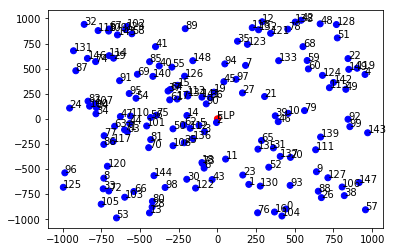

In [46]:
#On créer une situation de test simple
N_clients = 150 #Nombre de clients
N_triporteurs = 10 #Nombre de triporteurs
R = 1000 #Côté du carré qui délimite la zone ou se trouvent les clients

Liste_Clients = [Client(str(k), Point(random.randint(-R, R), random.randint(-R, R)), 0, 1000, 1) for k in range(N_clients)] #Liste de clients placés au hasard
ELP = Client("ELP", Point(0,0), 0, 1000, 0) #On créer l'ELP au centre de la carte
situation = Situation(ELP, Liste_Clients, N_triporteurs) #On met tout dans un objet situation

#Un petit affichage
X,Y,C = situation.Plt()
fig, ax = plt.subplots()
ax.scatter(X,Y, c=C)
for xi, yi, client in zip(X,Y,[ELP] + Liste_Clients):
    ax.annotate(str(client.nom), xy=(xi,yi))
plt.show()

In [47]:
ag = AG(situation, pop = 100, n_generations = 20000,
        p_clones = 0.60, p_meilleurs = 0.30, p_randoms = 0.10,
        n_max_mutations = 5)
repartition, score = ag.lancer()[0]

Debut de l'algorithme
Nombre de générations à faire : 20000
Population par génération : 100
Proportion de meilleurs individus à garder : 0.3
Proportion d'individus pris de manièere aléatoire : 0.1
Proportion de clones mutés à faire : 0.6
Verification : p_meilleurs + p_randoms + p_clones = 1.0
Nombre maximal de mutation sur un clone : 5
#####
Generation 0
pop = 99.99195313421544
n_meilleurs = 30
n_randoms = 10
n_clones = 60
Taille de new_generation : 100
Meilleur chemin : [[ELP, 103, 52, 27, 77, 106, 136, 44, 130, 120, 105, 92, 19, 10, 60, 85, ELP], [ELP, 135, 39, 42, 57, 146, 109, 129, 18, 29, 107, 138, 118, 25, 111, 36, ELP], [ELP, 139, 68, 114, 67, 73, 8, 72, 110, 12, 123, 134, 17, 15, 137, 38, ELP], [ELP, 119, 63, 84, 132, 95, 3, 66, 23, 28, 0, 16, 145, 26, 53, 89, ELP], [ELP, 14, 116, 41, 94, 141, 5, 148, 128, 99, 90, 133, 48, 7, 108, 144, ELP], [ELP, 56, 35, 101, 59, 65, 22, 142, 69, 86, 82, 49, 62, 46, 75, 149, ELP], [ELP, 104, 13, 125, 131, 78, 112, 32, 126, 50, 24, 45, 102, 58,

#####
Generation 18000
pop = 23.49048846154333
n_meilleurs = 7
n_randoms = 2
n_clones = 14
Taille de new_generation : 23
Meilleur chemin : [[ELP, 3, 62, 50, 101, 15, 85, 126, 148, 123, 35, 133, 22, 119, 149, 128, 138, 68, 59, 27, 36, 141, 90, ELP], [ELP, 139, 106, 38, 122, 73, 18, 97, 7, 60, 49, 4, ELP], [ELP, 37, 145, 109, 102, 116, 142, 79, ELP], [ELP, 5, 61, 144, 98, 127, 9, 26, 88, 93, 130, 65, 135, 6, 30, 28, 80, 66, 105, 103, 13, 53, 72, ELP], [ELP, 17, 129, 67, 58, 118, 32, 136, ELP], [ELP, 2, 96, 125, 33, 8, 120, 46, 115, 21, 10, 39, ELP], [ELP, 14, 113, 64, 54, 95, 140, 131, 146, 74, 29, 114, 87, 84, 107, 100, 24, 82, 44, 63, 47, 77, 86, 117, 71, 83, 70, 16, 0, ELP], [ELP, 112, 108, 25, 81, 56, 110, 69, 132, 121, 51, 124, 99, 143, 92, ELP], [ELP, 134, 94, 78, 48, 42, 12, 89, 91, 34, 75, 43, 1, 23, 11, ELP], [ELP, 31, 20, 111, 147, 57, 76, 104, 137, 52, 55, 40, 41, 45, 19, ELP]]
Note : 277841772.12225366
En Moyenne : 321173730.1918099


In [42]:
repartition, score

([[ELP, 9, 8, 28, 21, 4, ELP],
  [ELP, 0, 11, 12, 10, 5, 7, 17, 19, 15, ELP],
  [ELP, 23, 20, 16, 26, 24, 6, 14, ELP],
  [ELP, 13, 29, 2, 27, ELP],
  [ELP, 1, 22, 3, 18, 25, ELP]],
 1399528.4122941573)

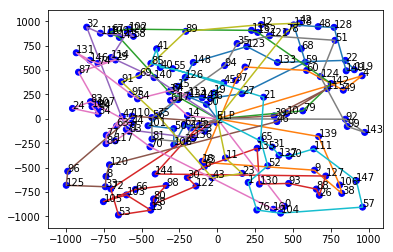

In [48]:
fig, ax = plt.subplots()
for chemin in repartition:
    ax.plot([c.position.x for c in chemin],[c.position.y for c in chemin])
X,Y,C = situation.Plt()
ax.scatter(X,Y, c=C)
for xi, yi, client in zip(X,Y,[ELP] + Liste_Clients):
    ax.annotate(str(client.nom), xy=(xi,yi))
plt.show()

In [11]:
Distance((Liste_Clients[9].position), Liste_Clients[9].position)

0.0

In [12]:
Liste_Clients[9].position

(56,48)

In [13]:
Liste_Clients[6].position

(11,95)

In [14]:
performances = AG.score_generation(generation)
performances_triees = sorted(performances, key=lambda x: x[1])
performances_triees

NameError: name 'generation' is not defined

In [ ]:
AG.meilleur_et_moyenne(generation)

In [ ]:
new_generation = [x[0] for x in performances_triees[:ag.n_meilleurs_a_prendre]]
new_generation

In [ ]:
clone = AG.clone(new_generation[np.random.randint(len(new_generation))])
clone

In [ ]:
new_generation.append(clone)
new_generation

In [ ]:
AG.faire_muter(clone)
new_generation